This script is used to produce Figure 4 (diatom and small phytoplankton NPP differences and N and light limitation terms) for the Payne et al. paper "End-of-century Arctic Ocean phytoplankton blooms start a month earlier due to anthropogenic climate change".


1. Import libraries

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cmo
import warnings
warnings.filterwarnings("ignore")

2. Read in bloom start (max_25) and end (max_25_2) files and npp during the bloom (npp_bloom) and total annual npp (npp_tot). These files were created for each year and across all ensemble members using the "BloomMetrics" script. Bloom start occurs on the date when biomass first surpasses 25% of the maximum biomass at any given grid cell, and end occurs on the date when biomass first diminishes below 25% of the maximum following the peak in biomass. I then set any zero values to 'nan'.

In [2]:
max_25 = np.zeros([14,384,320,50]); max_100 = np.zeros([14,384,320,50]); max_25_2 = np.zeros([14,384,320,50]); 
npp_tot = np.zeros([14,384,320,50]); npp_bloom = np.zeros([14,384,320,50]); 
for yrset in np.arange(0,14):
    yrnum = str(1970 + yrset*10)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25.txt")
    max_25[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25_2.txt")
    max_25_2[yrset,:,:,:] = dir.reshape(384,320,50)
    # dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_npp_bloom.txt")
    # npp_bloom[yrset,:,:,:] = dir.reshape(384,320,50)
    # dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_npp_tot.txt")
    # npp_tot[yrset,:,:,:] = dir.reshape(384,320,50)


3. Read in a randomly chosen NPP file. This is used to generate latitude (lat) and longitude (lon) fields for CESM files.

In [3]:
# Select a file
vdir = 'ocn'
vnam = 'photoC_diat_zint_2'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam + '/'
fnam = 'b.e21.BSSP370cmip6.f09_g17.LE2-1301.003.pop.h.ecosys.nday1.photoC_diat_zint_2.20450102-20550101.nc'

ncfile = xr.open_dataset(fdir + fnam)
lon = ncfile.TLONG.values
lat = ncfile.TLAT.values

# Interpolate lat and lon values over holes in the arrays
ok = ~np.isnan(lon)
xp = ok.ravel().nonzero()[0]
fp = lon[~np.isnan(lon)]
x  = np.isnan(lon).ravel().nonzero()[0]
lon[np.isnan(lon)] = np.interp(x, xp, fp)

ok = ~np.isnan(lat)
xp = ok.ravel().nonzero()[0]
fp = lat[~np.isnan(lat)]
x  = np.isnan(lat).ravel().nonzero()[0]
lat[np.isnan(lat)] = np.interp(x, xp, fp)

4. Make the areacello_ocn array that gives the area (in m2) of each grid cell in the larger region (latitude > 50°N).

In [4]:
# b. Open up the areacello (area for ocean grid cells) file. I'll use this to calculate sea ice areal coverage
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan); areacello_arc = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(ncfile['photoC_diat_zint_2'][180,i,j]) == False and ncfile["TLAT"][i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]
        if np.isnan(ncfile['photoC_diat_zint_2'][180,i,j]) == False and ncfile["TLAT"][i,j] > 66.5:
            areacello_arc[i,j] = areacello[i,j]


5. Read in diatom light and N limitation files for 1970, 2020, and 2100 from the CESM2-LE.

In [6]:
var = 'diat_light_lim_Cweight_avg_100m'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/month_1/'+ var + '/'
diat_llim_1970 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*197001*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    diat_llim_1970[ens,:,:,:] = ncfile[var][0:12,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
diat_llim_2020 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*201501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    diat_llim_2020[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
diat_llim_2100 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*209501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    diat_llim_2100[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100


In [5]:
var = 'diat_N_lim_Cweight_avg_100m'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/month_1/'+ var + '/'
diat_nlim_1970 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*197001*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    diat_nlim_1970[ens,:,:,:] = ncfile[var][0:12,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
diat_nlim_2020 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*201501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    diat_nlim_2020[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
diat_nlim_2100 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*209501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    diat_nlim_2100[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100


7. Read in small phytoplankton light and N limitation terms for 1970, 2020, and 2100. 

In [7]:
var = 'sp_light_lim_Cweight_avg_100m'#'diat_N_lim_Cweight_avg_100m'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/month_1/'+ var + '/'
sp_llim_1970 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*197001*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    sp_llim_1970[ens,:,:,:] = ncfile[var][0:12,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
sp_llim_2020 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*201501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    sp_llim_2020[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
sp_llim_2100 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*209501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    sp_llim_2100[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100


In [8]:
var = 'sp_N_lim_Cweight_avg_100m'#'diat_N_lim_Cweight_avg_100m'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/month_1/'+ var + '/'
sp_nlim_1970 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*197001*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    sp_nlim_1970[ens,:,:,:] = ncfile[var][0:12,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
sp_nlim_2020 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*201501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    sp_nlim_2020[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
sp_nlim_2100 = np.zeros([50,12,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*209501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    sp_nlim_2100[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100


8. In this loop, I first determine the month that the bloom starts and ends for each grid cell and each ensemble member. I then calculate '_av' limitation terms over the course of the bloom for each grid cell and each ensemble member.

In [9]:
# Days per month
dpm = [31,28,31,30,31,30,31,31,30,31,30,31]

# Set up bloom-averaged limitation term arrays 
diat_nlim_1970_av = np.zeros([50,384,320]); diat_nlim_2020_av = np.zeros([50,384,320]); diat_nlim_2100_av = np.zeros([50,384,320]); 
diat_llim_1970_av = np.zeros([50,384,320]); diat_llim_2020_av = np.zeros([50,384,320]); diat_llim_2100_av = np.zeros([50,384,320]); 
sp_nlim_1970_av = np.zeros([50,384,320]); sp_nlim_2020_av = np.zeros([50,384,320]); sp_nlim_2100_av = np.zeros([50,384,320]); 
sp_llim_1970_av = np.zeros([50,384,320]); sp_llim_2020_av = np.zeros([50,384,320]); sp_llim_2100_av = np.zeros([50,384,320]); 

# Bloom start and end for each grid cell
bs_70 = 0; be_70 = 0; bs_20 = 0; be_20 = 0; bs_00 = 0; be_00 = 0

# Loop over all grid cells
for i in np.arange(0,384):
    for j in np.arange(0,320):
        for ens in np.arange(0,50):
            ctr = -1
            for a in [1,32,60,91,121,152,182,213,244,274,305,335]:
                ctr += 1
                # Identify the start and end months of the bloom
                if max_25[0,i,j,ens] > a and max_25[0,i,j,ens] < a + dpm[ctr]:
                    bs_70 = (ctr + 1) + (max_25[0,i,j,ens]-a)/dpm[ctr]
                if max_25_2[0,i,j,ens] > a and max_25_2[0,i,j,ens] < a + dpm[ctr]:
                    be_70 = (ctr + 1) + (max_25_2[0,i,j,ens]-a)/dpm[ctr]
                if max_25[5,i,j,ens] > a and max_25[5,i,j,ens] < a + dpm[ctr]:
                    bs_20 = (ctr + 1) + (max_25[5,i,j,ens]-a)/dpm[ctr]
                if max_25_2[5,i,j,ens] > a and max_25_2[5,i,j,ens] < a + dpm[ctr]:
                    be_20 = (ctr + 1) + (max_25_2[5,i,j,ens]-a)/dpm[ctr]
                if max_25[13,i,j,ens] > a and max_25[13,i,j,ens] < a + dpm[ctr]:
                    bs_00 = (ctr + 1) + (max_25[13,i,j,ens]-a)/dpm[ctr]
                if max_25_2[13,i,j,ens] > a and max_25_2[13,i,j,ens] < a + dpm[ctr]:
                    be_00 = (ctr + 1) + (max_25_2[13,i,j,ens]-a)/dpm[ctr]
                    
            # Calculate the proportion of each month that occurs
            # during the bloom, and use this to sum light and N
            # limitation terms.
            ft = True; summ = 0
            for m in np.arange(0,12):
                if (m + 2) > bs_70 and (m+1) < be_70:
                    if ft == True:
                        monprop = m + 2 - bs_70
                        ft = False
                    elif (m+2) > be_70:
                        monprop = be_70 - m - 1
                    else:
                        monprop = 1
                    # Sum limitation terms, adjusted by number of
                    # days in the month and proportion of the month
                    # (monprop) that was during the bloom.
                    summ +=dpm[m]*monprop
                    diat_nlim_1970_av[ens,i,j] += diat_nlim_1970[ens,m,i,j] * monprop * dpm[m]
                    diat_llim_1970_av[ens,i,j] += diat_llim_1970[ens,m,i,j] * monprop * dpm[m]
                    sp_nlim_1970_av[ens,i,j] += sp_nlim_1970[ens,m,i,j] * monprop * dpm[m]
                    sp_llim_1970_av[ens,i,j] += sp_llim_1970[ens,m,i,j] * monprop * dpm[m]
            # Calculate av lim term by dividing the number of days 
            # of the bloom
            diat_nlim_1970_av[ens,i,j] = diat_nlim_1970_av[ens,i,j]/summ
            diat_llim_1970_av[ens,i,j] = diat_llim_1970_av[ens,i,j]/summ
            sp_nlim_1970_av[ens,i,j] = sp_nlim_1970_av[ens,i,j]/summ
            sp_llim_1970_av[ens,i,j] = sp_llim_1970_av[ens,i,j]/summ

            # Redo these calculations for 2020
            ft = True; summ = 0
            for m in np.arange(0,12):
                if (m + 2) > bs_20 and (m+1) < be_20:
                    if ft == True:
                        monprop = m + 2 - bs_20
                        ft = False
                    elif (m+2) > be_20:
                        monprop = be_20 - m - 1
                    else:
                        monprop = 1
                    summ +=dpm[m]*monprop
                    diat_nlim_2020_av[ens,i,j] += diat_nlim_2020[ens,m,i,j]* monprop * dpm[m]
                    diat_llim_2020_av[ens,i,j] += diat_llim_2020[ens,m,i,j]* monprop * dpm[m]
                    sp_nlim_2020_av[ens,i,j] += sp_nlim_2020[ens,m,i,j]* monprop * dpm[m]
                    sp_llim_2020_av[ens,i,j] += sp_llim_2020[ens,m,i,j]* monprop * dpm[m]
            diat_nlim_2020_av[ens,i,j] = diat_nlim_2020_av[ens,i,j]/summ
            diat_llim_2020_av[ens,i,j] = diat_llim_2020_av[ens,i,j]/summ
            sp_nlim_2020_av[ens,i,j] = sp_nlim_2020_av[ens,i,j]/summ
            sp_llim_2020_av[ens,i,j] = sp_llim_2020_av[ens,i,j]/summ

            # Redo these calculations for 2100
            ft = True; summ = 0
            for m in np.arange(0,12):
                if (m + 2) > bs_00 and (m+1) < be_00:
                    if ft == True:
                        monprop = m + 2 - bs_00
                        ft = False
                    elif (m+2) > be_00:
                        monprop = be_00 - m - 1
                    else:
                        monprop = 1
                    summ +=dpm[m]*monprop
                    diat_nlim_2100_av[ens,i,j] += diat_nlim_2100[ens,m,i,j]* monprop * dpm[m]
                    diat_llim_2100_av[ens,i,j] += diat_llim_2100[ens,m,i,j]* monprop * dpm[m]
                    sp_nlim_2100_av[ens,i,j] += sp_nlim_2100[ens,m,i,j]* monprop * dpm[m]
                    sp_llim_2100_av[ens,i,j] += sp_llim_2100[ens,m,i,j]* monprop * dpm[m]
            diat_nlim_2100_av[ens,i,j] = diat_nlim_2100_av[ens,i,j]/summ
            diat_llim_2100_av[ens,i,j] = diat_llim_2100_av[ens,i,j]/summ
            sp_nlim_2100_av[ens,i,j] = sp_nlim_2100_av[ens,i,j]/summ
            sp_llim_2100_av[ens,i,j] = sp_llim_2100_av[ens,i,j]/summ


9. Make Figures 4e-l by subtracting lim terms for 2020 or 2100 from 1970.

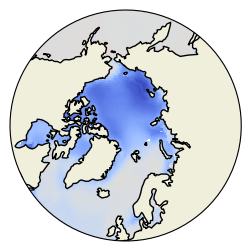

In [10]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set figure basics (size, projection)
fig = plt.figure(figsize=(3,3)) 
# fig = plt.figure(figsize=(6,6)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());

# plot changes in the actual variable of interest on top
pc = ax.pcolormesh(lon, lat, np.nanmean(sp_nlim_2100_av,axis=0) - np.nanmean(sp_nlim_1970_av,axis=0),
                   transform=ccrs.PlateCarree(), vmin = -.4, vmax = .4,  #-60 60, -20 20
                   cmap='coolwarm', zorder = 1); #coolwarm, BrBG_r

# add land on top and colorbar
ax.coastlines();  ax.add_feature(cfeature.LAND, zorder = 1); #plt.colorbar(pc, orientation='horizontal', extend='both');
# plt.colorbar(pc, orientation = 'horizontal');

# print this figure
# figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig4l.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# # plt.close()

10. I use this code to calculate statistics and values reported in the paper, including mean limitation terms over the Arctic and 50°N.

In [11]:
bs = np.zeros([50,384,320]);vari = np.zeros([50,384,320])
bs2 = np.zeros([50,384,320]);vari2 = np.zeros([50,384,320])
for ens in np.arange(0,50):
    bs[ens,:,:] =(max_25_2[0,:,:,ens])*areacello_arc
    bs2[ens,:,:] =(max_25_2[13,:,:,ens])*areacello_arc
    vari[ens,:,:] = sp_llim_1970_av[ens,:,:]*areacello_arc
    vari2[ens,:,:] = sp_llim_2100_av[ens,:,:]*areacello_arc

In [13]:
from scipy import stats
mask = ~np.isnan(vari) & ~np.isnan(bs) & ~np.isnan(vari2) & ~np.isnan(bs2)
a = stats.linregress(vari2[mask]-vari[mask],bs2[mask]-bs[mask])
print(a.rvalue*a.rvalue,a.pvalue)

0.014195615887003386 0.0


In [14]:
ocn_ens = np.zeros([50]); arc_ens = np.zeros([50])
for ens in np.arange(0,50):
    ocn_ens[ens] = np.nansum(sp_nlim_2100_av[ens,:,:] * areacello_ocn)/np.nansum(areacello_ocn)
    arc_ens[ens] = np.nansum(sp_nlim_2100_av[ens,:,:] * areacello_arc)/np.nansum(areacello_arc)

In [15]:
print(np.mean(ocn_ens), np.mean(arc_ens))

0.8428649230716232 0.7485150764539438


11. Read in diatom and small phytoplankton NPP individually for each ensemble member and for 1970, 2020, and 2100.

In [16]:
var = 'photoC_diat_zint'#'diat_N_lim_Cweight_avg_100m'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/month_1/'+ var + '/'
diatNPP_1970 = np.zeros([50,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*197001*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    diatNPP_1970[ens,:,:] = np.nanmean(ncfile[var][0:12,:,:],axis=0)*10.377*365 #0:12 for 1970, 48:60 for 2020 and 2100
diatNPP_2020 = np.zeros([50,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*201501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    diatNPP_2020[ens,:,:] = np.nanmean(ncfile[var][48:60,:,:],axis=0)*10.377*365 #0:12 for 1970, 48:60 for 2020 and 2100
diatNPP_2100 = np.zeros([50,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*209501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    diatNPP_2100[ens,:,:] = np.nanmean(ncfile[var][48:60,:,:],axis=0)*10.377*365 #0:12 for 1970, 48:60 for 2020 and 2100


In [17]:
var = 'photoC_sp_zint'#'diat_N_lim_Cweight_avg_100m'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/month_1/'+ var + '/'
spNPP_1970 = np.zeros([50,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*197001*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    spNPP_1970[ens,:,:] = np.nanmean(ncfile[var][0:12,:,:],axis=0)*10.377*365 #0:12 for 1970, 48:60 for 2020 and 2100
spNPP_2020 = np.zeros([50,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*201501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    spNPP_2020[ens,:,:] = np.nanmean(ncfile[var][48:60,:,:],axis=0)*10.377*365 #0:12 for 1970, 48:60 for 2020 and 2100
spNPP_2100 = np.zeros([50,384,320])
ens = -1
for file in glob.glob(fdir + "*smbb*209501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    spNPP_2100[ens,:,:] = np.nanmean(ncfile[var][48:60,:,:],axis=0)*10.377*365 #0:12 for 1970, 48:60 for 2020 and 2100


12. Make Figures 4a-d by plotting the proportion of NPP produced by diatoms and small phytoplankton in 1970 and 2100 (2020 looks very similar to 1970).

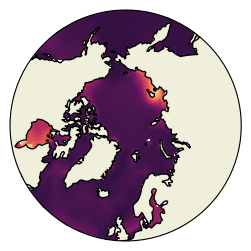

In [18]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set figure basics (size, projection)
fig = plt.figure(figsize=(3,3)) 
# fig = plt.figure(figsize=(6,6)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());

# plot changes in the actual variable of interest on top
pc = ax.pcolormesh(lon, lat, np.nanmean(diatNPP_2020,axis=0)/np.nanmean(diatNPP_2020 + spNPP_2020,axis=0),
                   transform=ccrs.PlateCarree(), vmin = 0, vmax = 1,  #-60 60, -20 20
                   cmap='cmo.matter', zorder = 1); #coolwarm, BrBG_r

# add land on top and colorbar
ax.coastlines();  ax.add_feature(cfeature.LAND, zorder = 1); #plt.colorbar(pc, orientation='horizontal', extend='both');
# plt.colorbar(pc, orientation = 'horizontal', extend = 'max');

# print this figure
# figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig4c.png';
# plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

13. Here, I include code I used to analyze differences between different regions (shelf and deep Arctic and sub-Arctic) in different environmental conditions (MLD, NO3, ice concentration). 

In [ ]:
# a. Read in array describing what region each grid cell corresponds to. Shelfmask numbers correspond to:
# 1: the shelf (<1000m) of the sub-Arctic (50-66.5°N)
# 2: the shelf (<1000m) of the Arctic (> 66.5°N)
# 3: the basin (>1000m) of the sub-Arctic (50-66.5°N)
# 4: the basin (>1000m) of the Arctic (> 66.5°N)

dir = np.loadtxt("/glade/u/home/cpayne/Projects/PredictPerfect/Input/shelfmask.txt")
shelfmask = dir.reshape(384,320)

In [ ]:
# Read in MLD data for each year
var = 'HMXL'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/month_1/'+ var + '/'
ens = -1
mld_1970 = np.zeros([50,12,384,320])
for file in glob.glob(fdir + "*smbb*197001*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    mld_1970[ens,:,:,:] = ncfile[var][0:12,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
ens = -1
mld_2020 = np.zeros([50,12,384,320])
for file in glob.glob(fdir + "*smbb*201501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    mld_2020[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100

ens = -1
mld_2100 = np.zeros([50,12,384,320])
for file in glob.glob(fdir + "*smbb*209501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    mld_2100[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100

In [ ]:
# Read in NO3 data for each year
var = 'NO3'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/month_1/'+ var + '/'
ens = -1
no3_1970 = np.zeros([50,12,384,320])
for file in glob.glob(fdir + "*smbb*197001*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    no3_1970[ens,:,:,:] = ncfile[var][0:12,0,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
ens = -1
no3_2020 = np.zeros([50,12,384,320])
for file in glob.glob(fdir + "*smbb*201501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    no3_2020[ens,:,:,:] = ncfile[var][48:60,0,:,:] #0:12 for 1970, 48:60 for 2020 and 2100

ens = -1
no3_2100 = np.zeros([50,12,384,320])
for file in glob.glob(fdir + "*smbb*209501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    no3_2100[ens,:,:,:] = ncfile[var][48:60,0,:,:] #0:12 for 1970, 48:60 for 2020 and 2100

In [ ]:
# Read in sea ice concentration data for each year
var = 'aice'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1/'+ var + '/'
ens = -1
aice_1970 = np.zeros([50,12,384,320])
for file in glob.glob(fdir + "*smbb*197001*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    aice_1970[ens,:,:,:] = ncfile[var][0:12,:,:] #0:12 for 1970, 48:60 for 2020 and 2100
ens = -1
aice_2020 = np.zeros([50,12,384,320])
for file in glob.glob(fdir + "*smbb*201501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    aice_2020[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100

ens = -1
aice_2100 = np.zeros([50,12,384,320])
for file in glob.glob(fdir + "*smbb*209501*"): 
    ens += 1
    ncfile = xr.open_dataset(file)
    aice_2100[ens,:,:,:] = ncfile[var][48:60,:,:] #0:12 for 1970, 48:60 for 2020 and 2100

In [ ]:
# Look at differences in these conditions at individual grid cells

# i = 322; j = 193; # Bering
# i = 342; j = 194; # Chukchi
# i = 341; j = 275; # Hudson
i = 372; j = 176; # Central
# i = 373; j = 40;  # Greenland

In [ ]:
# Calculate proportion of total NPP generated by diatoms
print(np.nanmean(diatNPP_1970[:,i,j]/(diatNPP_1970[:,i,j] + spNPP_1970[:,i,j])))
print(np.nanmean(diatNPP_2020[:,i,j]/(diatNPP_2020[:,i,j] + spNPP_2020[:,i,j])))
print(np.nanmean(diatNPP_2100[:,i,j]/(diatNPP_2100[:,i,j] + spNPP_2100[:,i,j])))

In [ ]:
# Look at differences in March MLD and NO3
print(np.nanmean(no3_1970[:,2,i,j]),np.nanmean(no3_2020[:,2,i,j]),np.nanmean(no3_2100[:,2,i,j]))
print(np.nanmean(mld_1970[:,2,i,j])/1e2,np.nanmean(mld_2020[:,2,i,j])/1e2,np.nanmean(mld_2100[:,2,i,j])/1e2)

In [ ]:
# Calculate differences in MLD conditions for each region
lim_1970_shel = np.zeros([4,50,12]);lim_2020_shel = np.zeros([4,50,12]);lim_2100_shel = np.zeros([4,50,12])
for shel in np.arange(0,4):
    shelarea = 0
    for i in np.arange(0,384):
        for j in np.arange(0,320):
            if shelfmask[i,j] == shel + 1 and np.isnan(areacello_ocn[i,j]) == False:
                lim_1970_shel[shel,:,:] = mld_1970[:,:, i, j]/1e2*areacello_ocn[i,j] + lim_1970_shel[shel,:,:]
                lim_2020_shel[shel,:,:] = mld_2020[:,:, i, j]/1e2*areacello_ocn[i,j] + lim_2020_shel[shel,:,:]
                lim_2100_shel[shel,:,:] = mld_2100[:,:, i, j]/1e2*areacello_ocn[i,j] + lim_2100_shel[shel,:,:]
                shelarea = shelarea + areacello_ocn[i,j]
    lim_1970_shel[shel,:,:] = lim_1970_shel[shel,:,:]/shelarea
    lim_2020_shel[shel,:,:] = lim_2020_shel[shel,:,:]/shelarea
    lim_2100_shel[shel,:,:] = lim_2100_shel[shel,:,:]/shelarea


In [ ]:
# Compute MLD means for each year for the region > 50°N
mld_1970_arc = np.zeros([50,12]); mld_2020_arc = np.zeros([50,12]); mld_2100_arc = np.zeros([50,12]);
for ens in np.arange(0,50):
    for m in np.arange(0,12):
        mld_1970_arc[ens,m] = np.nansum(no3_1970[ens,m,:,:] * areacello_ocn)/np.nansum(areacello_ocn)#/1e2
        mld_2020_arc[ens,m] = np.nansum(no3_2020[ens,m,:,:] * areacello_ocn)/np.nansum(areacello_ocn)#/1e2
        mld_2100_arc[ens,m] = np.nansum(no3_2100[ens,m,:,:] * areacello_ocn)/np.nansum(areacello_ocn)#/1e2